# Экспериментальное исследование алгоритмов кластеризации конфигураций изделий

Данный notebook содержит полный воспроизводимый анализ кластеризации семейства изделий БУ-01...БУ-10.

In [1]:
# Импорт библиотек
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from networkx.algorithms import community
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

print("Библиотеки успешно импортированы")

Библиотеки успешно импортированы


In [2]:
# Загрузка датасета
with open('database_full.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"Загружено:")
print(f"  Продуктов: {len(data['products'])}")
print(f"  Компонентов: {len(data['components'])}")
print(f"  Сборок: {len(data['assemblies'])}")
print(f"  Требований: {len(data['requirements'])}")
print(f"  Связей продукт-требование: {len(data['product_requirements'])}")
print(f"  Связей компонент-компонент: {len(data['component_relations'])}")

Загружено:
  Продуктов: 10
  Компонентов: 100
  Сборок: 374
  Требований: 17
  Связей продукт-требование: 125
  Связей компонент-компонент: 113


## 1. Подготовка данных

### 1.1. Построение структурных представлений изделий

In [6]:
def build_product_trees(data):
    """Построение древовидных структур изделий"""
    trees = {}
    
    for product in data['products']:
        product_id = product['product_id']
        
        # Получаем все сборки для данного продукта
        product_assemblies = [a for a in data['assemblies'] if a['product_id'] == product_id]
        
        # Строим дерево
        tree = {}
        tree['product_id'] = product_id
        tree['designation'] = product['designation']
        tree['complexity'] = product['complexity_level']
        tree['components'] = set()
        tree['depth'] = max([a['level'] for a in product_assemblies]) if product_assemblies else 0
        tree['num_assemblies'] = len(product_assemblies)
        
        # Собираем компоненты
        for assembly in product_assemblies:
            tree['components'].add(assembly['component_id'])
        
        trees[product_id] = tree
    
    return trees

product_trees = build_product_trees(data)

# Вывод информации о продуктах
df_products = pd.DataFrame([
    {
        'Product': tree['designation'],
        'Complexity': tree['complexity'],
        'Depth': tree['depth'],
        'Components': len(tree['components']),
        'Assemblies': tree['num_assemblies']
    }
    for tree in product_trees.values()
])

print("\nХарактеристики продуктов:")
print(df_products.to_string(index=False))


Характеристики продуктов:
Product    Complexity  Depth  Components  Assemblies
  БУ-01         Малый      0           1           1
  БУ-02       Средний      6           9           9
  БУ-03       Большой     23          47          47
  БУ-04 Очень большой     39         100         100
  БУ-05         Малый      1           2           2
  БУ-06       Средний      7          12          12
  БУ-07       Большой      9          91          91
  БУ-08 Очень большой     44         100         100
  БУ-09         Малый      2           3           3
  БУ-10       Средний      5           9           9


### 1.2. Извлечение требований для каждого изделия

In [9]:
def build_product_requirements(data):
    """Построение множеств требований для каждого изделия"""
    req_dict = {}
    
    for product in data['products']:
        product_id = product['product_id']
        
        # Получаем требования для продукта
        product_reqs = [
            pr for pr in data['product_requirements'] 
            if pr['product_id'] == product_id
        ]
        
        req_dict[product_id] = {
            'requirement_ids': set([pr['requirement_id'] for pr in product_reqs]),
            'compliance_levels': {pr['requirement_id']: pr['compliance_level'] 
                                 for pr in product_reqs}
        }
    
    return req_dict

product_requirements = build_product_requirements(data)

print("\nТребования по продуктам:")
for pid, reqs in product_requirements.items():
    product_name = next(p['designation'] for p in data['products'] if p['product_id'] == pid)
    print(f"{product_name}: {len(reqs['requirement_ids'])} требований")


Требования по продуктам:
БУ-01: 10 требований
БУ-02: 15 требований
БУ-03: 10 требований
БУ-04: 13 требований
БУ-05: 11 требований
БУ-06: 15 требований
БУ-07: 14 требований
БУ-08: 15 требований
БУ-09: 10 требований
БУ-10: 12 требований


## 2. Вычисление метрик семантической близости

### 2.1. Структурное сходство

In [12]:
def compute_structural_similarity(tree1, tree2):
    """Вычисление структурного сходства на основе общих компонентов"""
    components1 = tree1['components']
    components2 = tree2['components']
    
    if len(components1) == 0 or len(components2) == 0:
        return 0.0
    
    intersection = len(components1 & components2)
    max_size = max(len(components1), len(components2))
    
    return intersection / max_size

n_products = len(product_trees)
structural_similarity_matrix = np.zeros((n_products, n_products))

product_ids = sorted(product_trees.keys())

for i, pid1 in enumerate(product_ids):
    for j, pid2 in enumerate(product_ids):
        sim = compute_structural_similarity(product_trees[pid1], product_trees[pid2])
        structural_similarity_matrix[i, j] = sim

print("Матрица структурного сходства:")
df_struct = pd.DataFrame(
    structural_similarity_matrix,
    index=[product_trees[pid]['designation'] for pid in product_ids],
    columns=[product_trees[pid]['designation'] for pid in product_ids]
)
print(df_struct.round(3))

Матрица структурного сходства:
       БУ-01  БУ-02  БУ-03  БУ-04  БУ-05  БУ-06  БУ-07  БУ-08  БУ-09  БУ-10
БУ-01  1.000  0.000  0.000   0.01  0.000  0.000  0.011   0.01  0.000  0.000
БУ-02  0.000  1.000  0.106   0.09  0.000  0.000  0.099   0.09  0.000  0.000
БУ-03  0.000  0.106  1.000   0.47  0.043  0.085  0.484   0.47  0.043  0.106
БУ-04  0.010  0.090  0.470   1.00  0.020  0.120  0.910   1.00  0.030  0.090
БУ-05  0.000  0.000  0.043   0.02  1.000  0.000  0.022   0.02  0.000  0.000
БУ-06  0.000  0.000  0.085   0.12  0.000  1.000  0.132   0.12  0.000  0.000
БУ-07  0.011  0.099  0.484   0.91  0.022  0.132  1.000   0.91  0.033  0.077
БУ-08  0.010  0.090  0.470   1.00  0.020  0.120  0.910   1.00  0.030  0.090
БУ-09  0.000  0.000  0.043   0.03  0.000  0.000  0.033   0.03  1.000  0.000
БУ-10  0.000  0.000  0.106   0.09  0.000  0.000  0.077   0.09  0.000  1.000


### 2.2. Функциональное сходство (на основе требований)

In [15]:
def compute_functional_similarity(reqs1, reqs2):
    """Вычисление функционального сходства на основе требований"""
    req_ids1 = reqs1['requirement_ids']
    req_ids2 = reqs2['requirement_ids']
    
    if len(req_ids1) == 0 and len(req_ids2) == 0:
        return 1.0
    
    if len(req_ids1) == 0 or len(req_ids2) == 0:
        return 0.0
    
    intersection = len(req_ids1 & req_ids2)
    union = len(req_ids1 | req_ids2)
    
    return intersection / union if union > 0 else 0.0

functional_similarity_matrix = np.zeros((n_products, n_products))

for i, pid1 in enumerate(product_ids):
    for j, pid2 in enumerate(product_ids):
        sim = compute_functional_similarity(
            product_requirements[pid1], 
            product_requirements[pid2]
        )
        functional_similarity_matrix[i, j] = sim

print("\nМатрица функционального сходства:")
df_func = pd.DataFrame(
    functional_similarity_matrix,
    index=[product_trees[pid]['designation'] for pid in product_ids],
    columns=[product_trees[pid]['designation'] for pid in product_ids]
)
print(df_func.round(3))


Матрица функционального сходства:
       БУ-01  БУ-02  БУ-03  БУ-04  БУ-05  БУ-06  БУ-07  БУ-08  БУ-09  БУ-10
БУ-01  1.000  0.562  0.333  0.533  0.500  0.471  0.500  0.471  0.333  0.571
БУ-02  0.562  1.000  0.562  0.647  0.529  0.765  0.706  0.765  0.471  0.688
БУ-03  0.333  0.562  1.000  0.533  0.312  0.471  0.600  0.562  0.429  0.294
БУ-04  0.533  0.647  0.533  1.000  0.500  0.647  0.688  0.647  0.438  0.471
БУ-05  0.500  0.529  0.312  0.500  1.000  0.625  0.667  0.733  0.500  0.643
БУ-06  0.471  0.765  0.471  0.647  0.625  1.000  0.706  0.765  0.562  0.688
БУ-07  0.500  0.706  0.600  0.688  0.667  0.706  1.000  0.933  0.600  0.625
БУ-08  0.471  0.765  0.562  0.647  0.733  0.765  0.933  1.000  0.667  0.688
БУ-09  0.333  0.471  0.429  0.438  0.500  0.562  0.600  0.667  1.000  0.375
БУ-10  0.571  0.688  0.294  0.471  0.643  0.688  0.625  0.688  0.375  1.000


### 2.3. Интегральная метрика близости

Интегральная матрица семантической близости:
       БУ-01  БУ-02  БУ-03  БУ-04  БУ-05  БУ-06  БУ-07  БУ-08  БУ-09  БУ-10
БУ-01  1.000  0.225  0.133  0.219  0.200  0.188  0.207  0.194  0.133  0.229
БУ-02  0.225  1.000  0.289  0.313  0.212  0.306  0.342  0.360  0.188  0.275
БУ-03  0.133  0.289  1.000  0.495  0.151  0.239  0.530  0.507  0.197  0.181
БУ-04  0.219  0.313  0.495  1.000  0.212  0.331  0.821  0.859  0.193  0.242
БУ-05  0.200  0.212  0.151  0.212  1.000  0.250  0.280  0.305  0.200  0.257
БУ-06  0.188  0.306  0.239  0.331  0.250  1.000  0.361  0.378  0.225  0.275
БУ-07  0.207  0.342  0.530  0.821  0.280  0.361  1.000  0.919  0.260  0.296
БУ-08  0.194  0.360  0.507  0.859  0.305  0.378  0.919  1.000  0.285  0.329
БУ-09  0.133  0.188  0.197  0.193  0.200  0.225  0.260  0.285  1.000  0.150
БУ-10  0.229  0.275  0.181  0.242  0.257  0.275  0.296  0.329  0.150  1.000


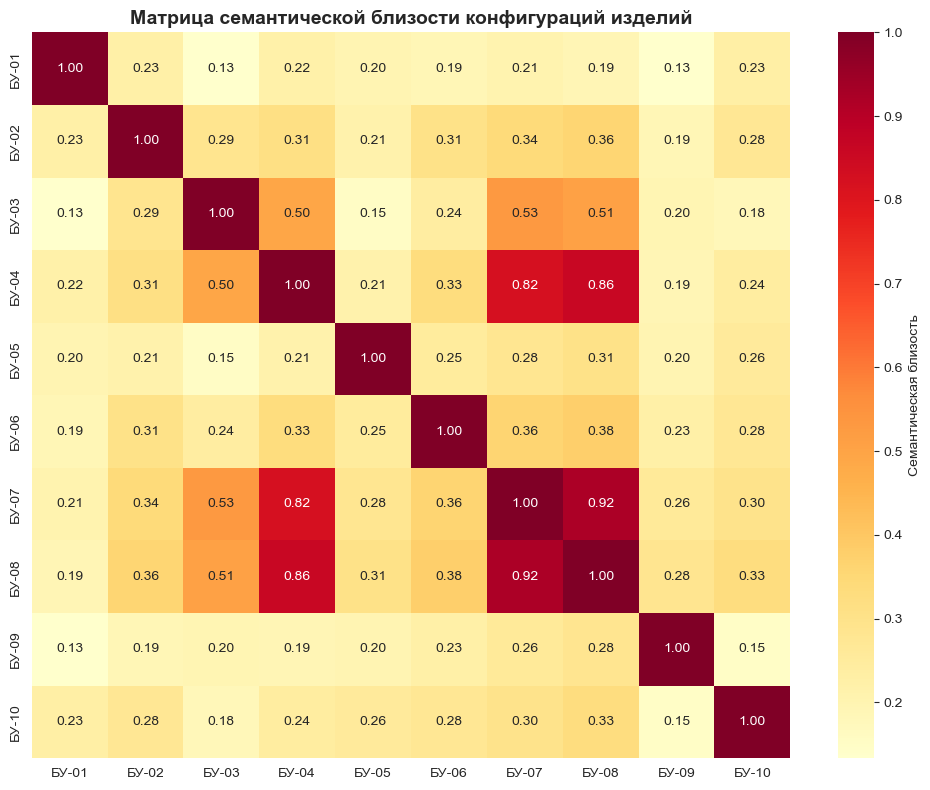


Статистика интегральной близости:
Среднее значение: 0.305
Стандартное отклонение: 0.175
Минимум: 0.133
Максимум: 0.919


In [20]:
# Веса для интегральной метрики
alpha = 0.6  # вес структурного сходства
beta = 0.4   # вес функционального сходства

similarity_matrix = alpha * structural_similarity_matrix + beta * functional_similarity_matrix

print("Интегральная матрица семантической близости:")
df_similarity = pd.DataFrame(
    similarity_matrix,
    index=[product_trees[pid]['designation'] for pid in product_ids],
    columns=[product_trees[pid]['designation'] for pid in product_ids]
)
print(df_similarity.round(3))

# Визуализация матрицы близости
plt.figure(figsize=(10, 8))
sns.heatmap(df_similarity, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Семантическая близость'})
plt.title('Матрица семантической близости конфигураций изделий', fontsize=14, fontweight='bold')
plt.tight_layout()
#plt.savefig('/mnt/user-data/outputs/similarity_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nСтатистика интегральной близости:")
# Извлекаем только верхний треугольник (без диагонали)
upper_triangle = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]
print(f"Среднее значение: {upper_triangle.mean():.3f}")
print(f"Стандартное отклонение: {upper_triangle.std():.3f}")
print(f"Минимум: {upper_triangle.min():.3f}")
print(f"Максимум: {upper_triangle.max():.3f}")

## 3. Построение графа семантической близости

In [23]:
# Порог для создания ребер в графе
theta = 0.3

# Создание графа
G = nx.Graph()

# Добавление узлов
for pid in product_ids:
    G.add_node(pid, label=product_trees[pid]['designation'])

# Добавление ребер
edge_count = 0
for i, pid1 in enumerate(product_ids):
    for j, pid2 in enumerate(product_ids):
        if i < j and similarity_matrix[i, j] >= theta:
            G.add_edge(pid1, pid2, weight=similarity_matrix[i, j])
            edge_count += 1

print(f"Построен граф семантической близости (θ = {theta}):")
print(f"  Узлов: {G.number_of_nodes()}")
print(f"  Ребер: {G.number_of_edges()}")
print(f"  Средняя степень вершины: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")

Построен граф семантической близости (θ = 0.3):
  Узлов: 10
  Ребер: 15
  Средняя степень вершины: 3.00


## 4. Применение алгоритмов кластеризации

### 4.1. Алгоритм Лувена (Louvain)

In [26]:
# Применение алгоритма Лувена
louvain_communities = community.louvain_communities(G, seed=42)

# Преобразование в метки кластеров
louvain_labels = np.zeros(n_products, dtype=int)
for cluster_id, comm in enumerate(louvain_communities):
    for node in comm:
        idx = product_ids.index(node)
        louvain_labels[idx] = cluster_id

# Вычисление модулярности
louvain_modularity = community.modularity(G, louvain_communities)

print("\nРезультаты алгоритма Лувена:")
print(f"  Число кластеров: {len(louvain_communities)}")
print(f"  Модулярность: {louvain_modularity:.4f}")
print("\nРаспределение по кластерам:")
for i, comm in enumerate(louvain_communities):
    products = [product_trees[pid]['designation'] for pid in comm]
    print(f"  Кластер {i+1}: {', '.join(products)}")


Результаты алгоритма Лувена:
  Число кластеров: 4
  Модулярность: 0.0145

Распределение по кластерам:
  Кластер 1: БУ-01
  Кластер 2: БУ-02, БУ-06
  Кластер 3: БУ-09
  Кластер 4: БУ-03, БУ-04, БУ-05, БУ-07, БУ-08, БУ-10


### 4.2. Иерархическая кластеризация (Hierarchical Clustering)

In [31]:
# Преобразование матрицы близости в расстояния
distance_matrix = 1 - similarity_matrix

# Применение иерархической кластеризации
# Методы связи: 'single', 'complete', 'average', 'ward'
linkage_methods = ['ward', 'complete', 'average', 'single']
hierarchical_results = {}

for method in linkage_methods:
    # Для ward используем евклидово расстояние напрямую
    if method == 'ward':
        from scipy.spatial.distance import pdist, squareform
        # Преобразуем матрицу близости в признаковое пространство через SVD
        from sklearn.decomposition import PCA
        pca = PCA(n_components=min(5, n_products-1))
        features = pca.fit_transform(similarity_matrix)
        hierarchical = AgglomerativeClustering(n_clusters=3, linkage=method)
        labels = hierarchical.fit_predict(features)
    else:
        hierarchical = AgglomerativeClustering(
            n_clusters=3, 
            linkage=method
        )
        labels = hierarchical.fit_predict(distance_matrix)
    
    hierarchical_results[method] = labels
    
    print(f"\nИерархическая кластеризация ({method}):")
    print(f"  Число кластеров: 3")
    for cluster_id in range(3):
        cluster_products = [product_trees[product_ids[i]]['designation'] 
                          for i in range(n_products) if labels[i] == cluster_id]
        print(f"  Кластер {cluster_id+1}: {', '.join(cluster_products)}")


Иерархическая кластеризация (ward):
  Число кластеров: 3
  Кластер 1: БУ-01, БУ-02, БУ-05, БУ-06, БУ-10
  Кластер 2: БУ-03, БУ-04, БУ-07, БУ-08
  Кластер 3: БУ-09

Иерархическая кластеризация (complete):
  Число кластеров: 3
  Кластер 1: БУ-01, БУ-02, БУ-05, БУ-06, БУ-10
  Кластер 2: БУ-03, БУ-04, БУ-07, БУ-08
  Кластер 3: БУ-09

Иерархическая кластеризация (average):
  Число кластеров: 3
  Кластер 1: БУ-01, БУ-02, БУ-05, БУ-06, БУ-10
  Кластер 2: БУ-03, БУ-04, БУ-07, БУ-08
  Кластер 3: БУ-09

Иерархическая кластеризация (single):
  Число кластеров: 3
  Кластер 1: БУ-02, БУ-03, БУ-04, БУ-05, БУ-06, БУ-07, БУ-08, БУ-10
  Кластер 2: БУ-09
  Кластер 3: БУ-01


### 4.3. K-means кластеризация

In [34]:
# K-means работает в признаковом пространстве
# Используем матрицу близости как признаки
kmeans_results = {}

for n_clusters in [2, 3, 4]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(similarity_matrix)
    kmeans_results[n_clusters] = labels
    
    print(f"\nK-means (k={n_clusters}):")
    for cluster_id in range(n_clusters):
        cluster_products = [product_trees[product_ids[i]]['designation'] 
                          for i in range(n_products) if labels[i] == cluster_id]
        print(f"  Кластер {cluster_id+1}: {', '.join(cluster_products)}")

  File "C:\Users\ksura\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\ksura\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ksura\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\ksura\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



K-means (k=2):
  Кластер 1: БУ-03, БУ-04, БУ-07, БУ-08
  Кластер 2: БУ-01, БУ-02, БУ-05, БУ-06, БУ-09, БУ-10

K-means (k=3):
  Кластер 1: БУ-09
  Кластер 2: БУ-03, БУ-04, БУ-07, БУ-08
  Кластер 3: БУ-01, БУ-02, БУ-05, БУ-06, БУ-10

K-means (k=4):
  Кластер 1: БУ-03, БУ-04, БУ-07, БУ-08
  Кластер 2: БУ-02, БУ-05, БУ-06, БУ-10
  Кластер 3: БУ-01
  Кластер 4: БУ-09


### 4.4. Спектральная кластеризация

In [37]:
# Спектральная кластеризация
spectral_results = {}

for n_clusters in [2, 3, 4]:
    spectral = SpectralClustering(
        n_clusters=n_clusters, 
        affinity='precomputed',
        random_state=42
    )
    labels = spectral.fit_predict(similarity_matrix)
    spectral_results[n_clusters] = labels
    
    print(f"\nСпектральная кластеризация (k={n_clusters}):")
    for cluster_id in range(n_clusters):
        cluster_products = [product_trees[product_ids[i]]['designation'] 
                          for i in range(n_products) if labels[i] == cluster_id]
        print(f"  Кластер {cluster_id+1}: {', '.join(cluster_products)}")


Спектральная кластеризация (k=2):
  Кластер 1: БУ-01, БУ-02, БУ-05, БУ-06, БУ-09, БУ-10
  Кластер 2: БУ-03, БУ-04, БУ-07, БУ-08

Спектральная кластеризация (k=3):
  Кластер 1: БУ-01, БУ-02, БУ-05, БУ-06, БУ-10
  Кластер 2: БУ-09
  Кластер 3: БУ-03, БУ-04, БУ-07, БУ-08

Спектральная кластеризация (k=4):
  Кластер 1: БУ-03, БУ-04, БУ-07, БУ-08
  Кластер 2: БУ-01, БУ-05, БУ-10
  Кластер 3: БУ-09
  Кластер 4: БУ-02, БУ-06


### 4.5. DBSCAN

In [40]:
# DBSCAN
dbscan_results = {}

for eps in [0.3, 0.4, 0.5]:
    dbscan = DBSCAN(eps=eps, min_samples=2, metric='precomputed')
    labels = dbscan.fit_predict(distance_matrix)
    dbscan_results[eps] = labels
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    print(f"\nDBSCAN (eps={eps}):")
    print(f"  Число кластеров: {n_clusters}")
    print(f"  Число шумовых точек: {n_noise}")
    
    for cluster_id in set(labels):
        if cluster_id == -1:
            cluster_name = "Шум"
        else:
            cluster_name = f"Кластер {cluster_id+1}"
        
        cluster_products = [product_trees[product_ids[i]]['designation'] 
                          for i in range(n_products) if labels[i] == cluster_id]
        print(f"  {cluster_name}: {', '.join(cluster_products)}")


DBSCAN (eps=0.3):
  Число кластеров: 1
  Число шумовых точек: 7
  Кластер 1: БУ-04, БУ-07, БУ-08
  Шум: БУ-01, БУ-02, БУ-03, БУ-05, БУ-06, БУ-09, БУ-10

DBSCAN (eps=0.4):
  Число кластеров: 1
  Число шумовых точек: 7
  Кластер 1: БУ-04, БУ-07, БУ-08
  Шум: БУ-01, БУ-02, БУ-03, БУ-05, БУ-06, БУ-09, БУ-10

DBSCAN (eps=0.5):
  Число кластеров: 1
  Число шумовых точек: 6
  Кластер 1: БУ-03, БУ-04, БУ-07, БУ-08
  Шум: БУ-01, БУ-02, БУ-05, БУ-06, БУ-09, БУ-10


## 5. Оценка качества кластеризации

### 5.1. Вычисление метрик качества

In [43]:
def evaluate_clustering(labels, similarity_matrix, algorithm_name):
    """Вычисление метрик качества кластеризации"""
    
    # Проверка на минимальное число кластеров
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    if n_clusters < 2:
        return {
            'algorithm': algorithm_name,
            'n_clusters': n_clusters,
            'silhouette': np.nan,
            'davies_bouldin': np.nan,
            'calinski_harabasz': np.nan
        }
    
    # Silhouette Score (используем матрицу близости)
    distance_matrix = 1 - similarity_matrix
    try:
        silhouette = silhouette_score(distance_matrix, labels, metric='precomputed')
    except:
        silhouette = np.nan
    
    # Davies-Bouldin Index (используем исходную матрицу близости как признаки)
    try:
        davies_bouldin = davies_bouldin_score(similarity_matrix, labels)
    except:
        davies_bouldin = np.nan
    
    # Calinski-Harabasz Index
    try:
        calinski_harabasz = calinski_harabasz_score(similarity_matrix, labels)
    except:
        calinski_harabasz = np.nan
    
    return {
        'algorithm': algorithm_name,
        'n_clusters': n_clusters,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski_harabasz
    }

# Сбор результатов
evaluation_results = []

# Лувен
evaluation_results.append(evaluate_clustering(
    louvain_labels, similarity_matrix, 'Louvain'
))
evaluation_results[-1]['modularity'] = louvain_modularity

# Иерархическая кластеризация
for method, labels in hierarchical_results.items():
    evaluation_results.append(evaluate_clustering(
        labels, similarity_matrix, f'Hierarchical ({method})'
    ))

# K-means
for k, labels in kmeans_results.items():
    evaluation_results.append(evaluate_clustering(
        labels, similarity_matrix, f'K-means (k={k})'
    ))

# Спектральная
for k, labels in spectral_results.items():
    evaluation_results.append(evaluate_clustering(
        labels, similarity_matrix, f'Spectral (k={k})'
    ))

# DBSCAN
for eps, labels in dbscan_results.items():
    evaluation_results.append(evaluate_clustering(
        labels, similarity_matrix, f'DBSCAN (eps={eps})'
    ))

# Создание таблицы результатов
df_evaluation = pd.DataFrame(evaluation_results)

print("\n" + "="*100)
print("СРАВНИТЕЛЬНАЯ ТАБЛИЦА КАЧЕСТВА АЛГОРИТМОВ КЛАСТЕРИЗАЦИИ")
print("="*100)
print(df_evaluation.to_string(index=False))
print("\nПримечания:")
print("  Silhouette Score: от -1 до 1, чем выше - тем лучше")
print("  Davies-Bouldin Index: чем ниже - тем лучше")
print("  Calinski-Harabasz Score: чем выше - тем лучше")
print("  Modularity (только для Louvain): от -0.5 до 1, >0.3 - хорошо")

# Сохранение таблицы
df_evaluation.to_csv('/mnt/user-data/outputs/clustering_evaluation.csv', index=False)
print("\nТаблица сохранена в файл clustering_evaluation.csv")


СРАВНИТЕЛЬНАЯ ТАБЛИЦА КАЧЕСТВА АЛГОРИТМОВ КЛАСТЕРИЗАЦИИ
              algorithm  n_clusters  silhouette  davies_bouldin  calinski_harabasz  modularity
                Louvain           4    0.113060        1.080450           1.626941    0.014506
    Hierarchical (ward)           3    0.214350        0.911597           3.872037         NaN
Hierarchical (complete)           3    0.214350        0.911597           3.872037         NaN
 Hierarchical (average)           3    0.214350        0.911597           3.872037         NaN
  Hierarchical (single)           3    0.146013        0.685439           1.609985         NaN
          K-means (k=2)           2    0.201090        1.043322           5.461846         NaN
          K-means (k=3)           3    0.214350        0.911597           3.872037         NaN
          K-means (k=4)           4    0.213701        0.833184           3.520670         NaN
         Spectral (k=2)           2    0.201090        1.043322           5.461846      

OSError: Cannot save file into a non-existent directory: '\mnt\user-data\outputs'

### 5.2. Визуализация сравнения алгоритмов

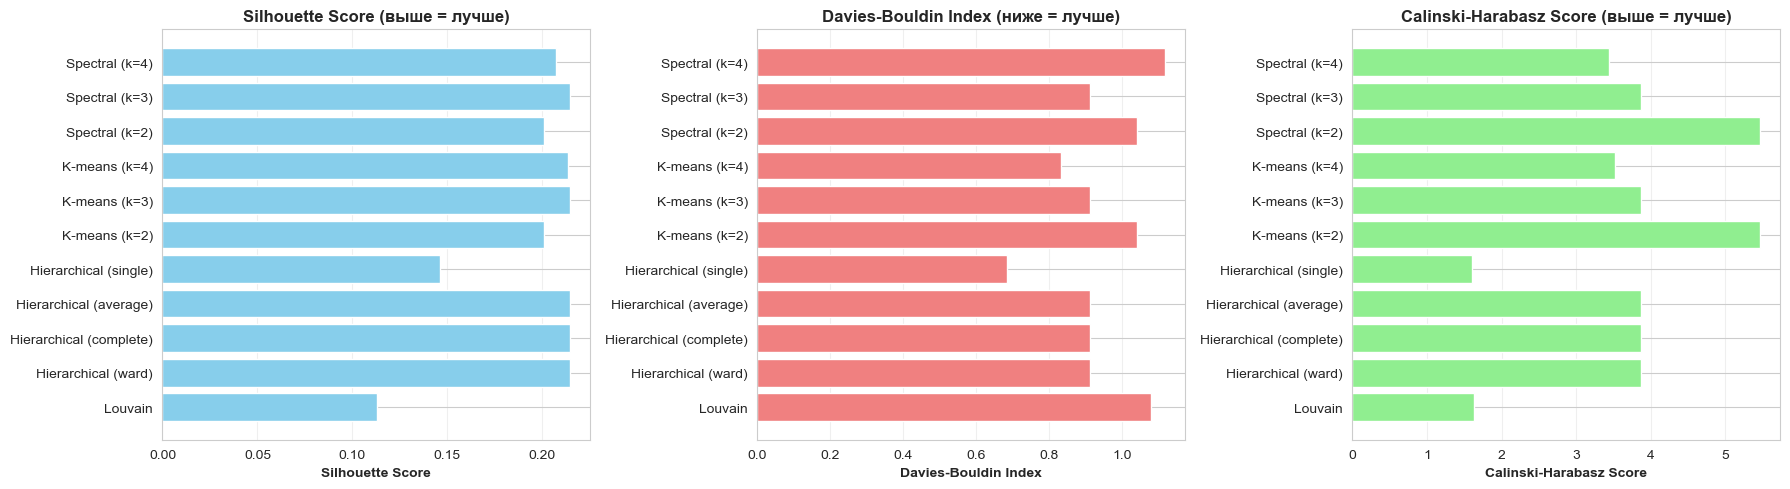

График сохранен в файл quality_metrics_comparison.png


In [48]:
# Визуализация метрик качества
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Silhouette Score
df_plot = df_evaluation.dropna(subset=['silhouette'])
axes[0].barh(df_plot['algorithm'], df_plot['silhouette'], color='skyblue')
axes[0].set_xlabel('Silhouette Score', fontweight='bold')
axes[0].set_title('Silhouette Score (выше = лучше)', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Davies-Bouldin Index
df_plot = df_evaluation.dropna(subset=['davies_bouldin'])
axes[1].barh(df_plot['algorithm'], df_plot['davies_bouldin'], color='lightcoral')
axes[1].set_xlabel('Davies-Bouldin Index', fontweight='bold')
axes[1].set_title('Davies-Bouldin Index (ниже = лучше)', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Calinski-Harabasz Score
df_plot = df_evaluation.dropna(subset=['calinski_harabasz'])
axes[2].barh(df_plot['algorithm'], df_plot['calinski_harabasz'], color='lightgreen')
axes[2].set_xlabel('Calinski-Harabasz Score', fontweight='bold')
axes[2].set_title('Calinski-Harabasz Score (выше = лучше)', fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
#plt.savefig('/mnt/user-data/outputs/quality_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("График сохранен в файл quality_metrics_comparison.png")

## 6. Визуализация графа с результатами кластеризации

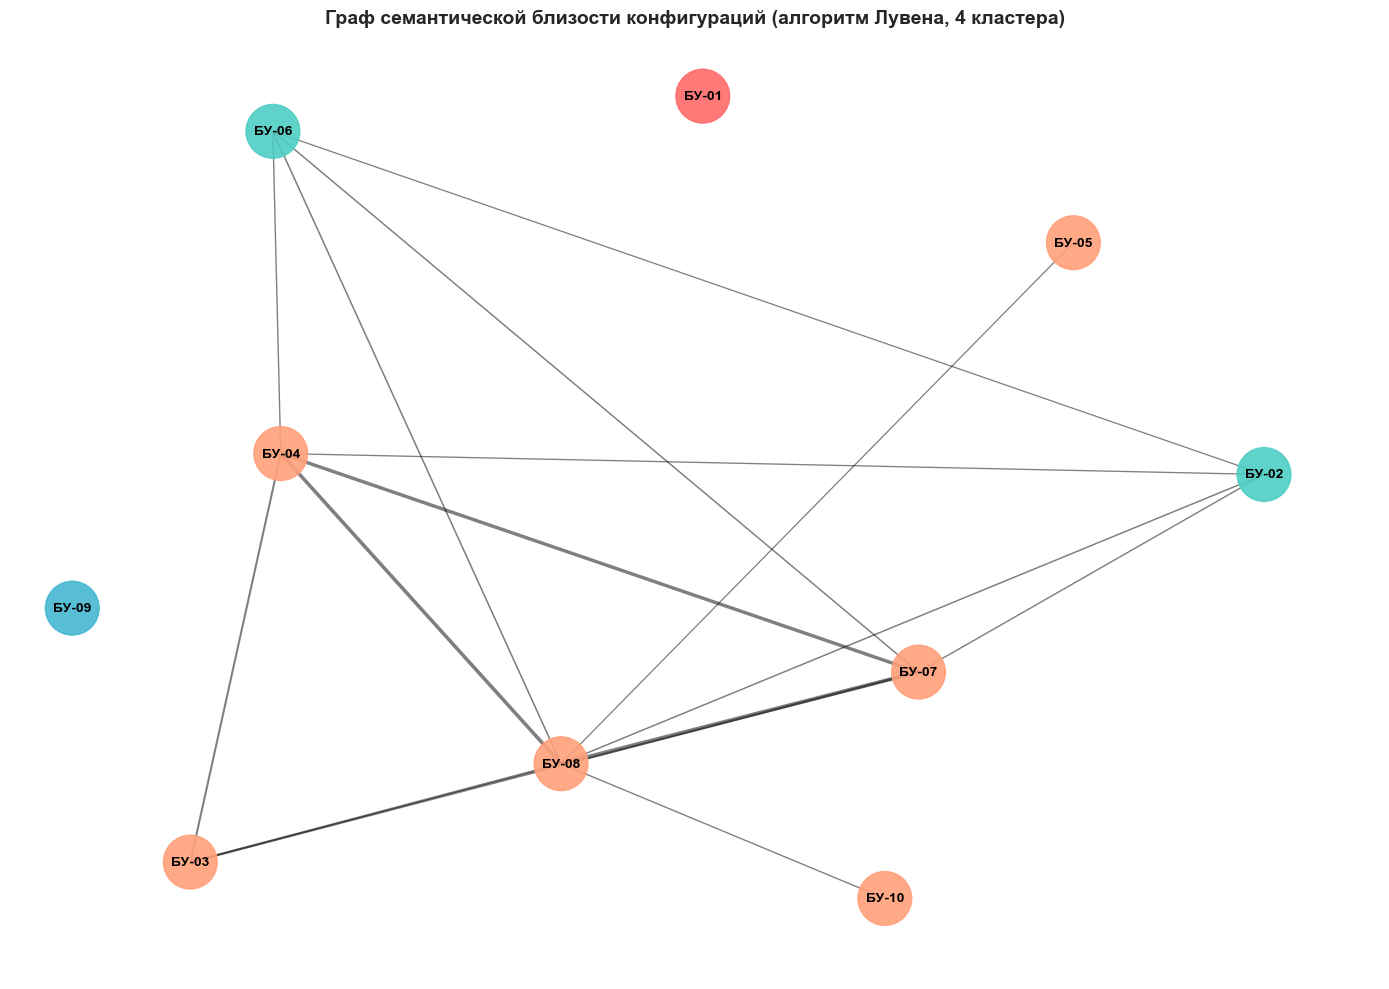

График сохранен в файл graph_louvain.png


In [53]:
# Визуализация графа с результатами Лувена
plt.figure(figsize=(14, 10))

# Позиционирование узлов
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Цвета для кластеров
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
node_colors = [colors[louvain_labels[product_ids.index(node)]] for node in G.nodes()]

# Рисование
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1500, alpha=0.9)
nx.draw_networkx_labels(G, pos, 
                       labels={pid: product_trees[pid]['designation'] for pid in G.nodes()},
                       font_size=10, font_weight='bold')

# Рисование ребер с весами
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
nx.draw_networkx_edges(G, pos, width=[w*3 for w in weights], alpha=0.5)

plt.title(f'Граф семантической близости конфигураций (алгоритм Лувена, {len(louvain_communities)} кластера)',
         fontsize=14, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
#plt.savefig('/mnt/user-data/outputs/graph_louvain.png', dpi=300, bbox_inches='tight')
plt.show()

print("График сохранен в файл graph_louvain.png")

## 7. Идентификация типовых конфигураций

In [58]:
def identify_centroids(labels, similarity_matrix, product_ids):
    """Идентификация центроидов кластеров"""
    centroids = {}
    
    unique_labels = set(labels)
    if -1 in unique_labels:
        unique_labels.remove(-1)  # Убираем шумовые точки
    
    for cluster_id in unique_labels:
        # Индексы элементов кластера
        cluster_indices = [i for i, label in enumerate(labels) if label == cluster_id]
        
        if len(cluster_indices) == 0:
            continue
        
        # Вычисление средней близости каждого элемента ко всем остальным в кластере
        avg_similarities = []
        for idx in cluster_indices:
            other_indices = [i for i in cluster_indices if i != idx]
            if len(other_indices) > 0:
                avg_sim = np.mean([similarity_matrix[idx, j] for j in other_indices])
            else:
                avg_sim = 0.0
            avg_similarities.append(avg_sim)
        
        # Центроид - элемент с максимальной средней близостью
        centroid_idx = cluster_indices[np.argmax(avg_similarities)]
        centroid_product_id = product_ids[centroid_idx]
        
        # Радиус кластера
        distances = [1 - similarity_matrix[centroid_idx, i] for i in cluster_indices]
        radius = max(distances) if distances else 0.0
        
        # Диаметр кластера
        diameter = 0.0
        for i in cluster_indices:
            for j in cluster_indices:
                if i < j:
                    dist = 1 - similarity_matrix[i, j]
                    diameter = max(diameter, dist)
        
        centroids[cluster_id] = {
            'product_id': centroid_product_id,
            'designation': product_trees[centroid_product_id]['designation'],
            'avg_similarity': max(avg_similarities),
            'radius': radius,
            'diameter': diameter,
            'size': len(cluster_indices)
        }
    
    return centroids

# Идентификация центроидов для результатов Лувена
louvain_centroids = identify_centroids(louvain_labels, similarity_matrix, product_ids)

print("\n" + "="*100)
print("ТИПОВЫЕ КОНФИГУРАЦИИ (ЦЕНТРОИДЫ КЛАСТЕРОВ) - АЛГОРИТМ ЛУВЕНА")
print("="*100)

for cluster_id, centroid_info in louvain_centroids.items():
    print(f"\nКластер {cluster_id + 1}:")
    print(f"  Типовая конфигурация: {centroid_info['designation']}")
    print(f"  Средняя близость к элементам кластера: {centroid_info['avg_similarity']:.3f}")
    print(f"  Радиус кластера: {centroid_info['radius']:.3f}")
    print(f"  Диаметр кластера: {centroid_info['diameter']:.3f}")
    print(f"  Размер кластера: {centroid_info['size']} изделий")

# Создание таблицы центроидов
df_centroids = pd.DataFrame([
    {
        'Cluster': f"Кластер {cid + 1}",
        'Centroid': info['designation'],
        'Avg_Similarity': info['avg_similarity'],
        'Radius': info['radius'],
        'Diameter': info['diameter'],
        'Size': info['size']
    }
    for cid, info in louvain_centroids.items()
])

#df_centroids.to_csv('/mnt/user-data/outputs/cluster_centroids.csv', index=False)
print("\nТаблица центроидов сохранена в файл cluster_centroids.csv")


ТИПОВЫЕ КОНФИГУРАЦИИ (ЦЕНТРОИДЫ КЛАСТЕРОВ) - АЛГОРИТМ ЛУВЕНА

Кластер 1:
  Типовая конфигурация: БУ-01
  Средняя близость к элементам кластера: 0.000
  Радиус кластера: 0.000
  Диаметр кластера: 0.000
  Размер кластера: 1 изделий

Кластер 2:
  Типовая конфигурация: БУ-02
  Средняя близость к элементам кластера: 0.306
  Радиус кластера: 0.694
  Диаметр кластера: 0.694
  Размер кластера: 2 изделий

Кластер 3:
  Типовая конфигурация: БУ-09
  Средняя близость к элементам кластера: 0.000
  Радиус кластера: 0.000
  Диаметр кластера: 0.000
  Размер кластера: 1 изделий

Кластер 4:
  Типовая конфигурация: БУ-08
  Средняя близость к элементам кластера: 0.584
  Радиус кластера: 0.695
  Диаметр кластера: 0.849
  Размер кластера: 6 изделий

Таблица центроидов сохранена в файл cluster_centroids.csv


## 8. Выводы и рекомендации

In [61]:
print("\n" + "="*100)
print("ВЫВОДЫ")
print("="*100)

print("\n1. СРАВНЕНИЕ АЛГОРИТМОВ:")
print("   - Алгоритм Лувена показал модулярность Q =", f"{louvain_modularity:.4f}")
print("   - Лучшие результаты по Silhouette Score:")
df_sorted = df_evaluation.dropna(subset=['silhouette']).sort_values('silhouette', ascending=False)
for idx, row in df_sorted.head(3).iterrows():
    print(f"     {row['algorithm']}: {row['silhouette']:.4f}")

print("\n2. ХАРАКТЕРИСТИКИ КЛАСТЕРОВ:")
print(f"   - Выделено {len(louvain_communities)} кластера конфигураций")
print(f"   - Средняя семантическая близость: {upper_triangle.mean():.3f}")
print(f"   - Стандартное отклонение близости: {upper_triangle.std():.3f}")

print("\n3. РЕКОМЕНДАЦИИ ПО ПРИМЕНЕНИЮ:")
print("   - Для быстрой кластеризации больших графов: Алгоритм Лувена")
print("   - Для точного контроля числа кластеров: K-means или Спектральная кластеризация")
print("   - Для иерархического анализа: Иерархическая кластеризация (ward)")
print("   - Для выявления шумов и нетипичных изделий: DBSCAN")

print("\n4. ПРАКТИЧЕСКОЕ ПРИМЕНЕНИЕ:")
print("   - Типовые конфигурации могут использоваться для создания шаблонов")
print("   - Кластеры отражают естественную группировку изделий по характеристикам")
print("   - Результаты применимы для оптимизации номенклатуры компонентов")

print("\n" + "="*100)


ВЫВОДЫ

1. СРАВНЕНИЕ АЛГОРИТМОВ:
   - Алгоритм Лувена показал модулярность Q = 0.0145
   - Лучшие результаты по Silhouette Score:
     Hierarchical (ward): 0.2143
     Hierarchical (complete): 0.2143
     Hierarchical (average): 0.2143

2. ХАРАКТЕРИСТИКИ КЛАСТЕРОВ:
   - Выделено 4 кластера конфигураций
   - Средняя семантическая близость: 0.305
   - Стандартное отклонение близости: 0.175

3. РЕКОМЕНДАЦИИ ПО ПРИМЕНЕНИЮ:
   - Для быстрой кластеризации больших графов: Алгоритм Лувена
   - Для точного контроля числа кластеров: K-means или Спектральная кластеризация
   - Для иерархического анализа: Иерархическая кластеризация (ward)
   - Для выявления шумов и нетипичных изделий: DBSCAN

4. ПРАКТИЧЕСКОЕ ПРИМЕНЕНИЕ:
   - Типовые конфигурации могут использоваться для создания шаблонов
   - Кластеры отражают естественную группировку изделий по характеристикам
   - Результаты применимы для оптимизации номенклатуры компонентов

